In [19]:
import numpy as np
import pandas as pd

import xgboost
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

from time import time

from sklearn.cross_validation import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display

%matplotlib inline

# Exploring the Data

In [53]:
path = 'E:\\unist\\skt\\'
data = pd.read_csv(path+'loan.csv')
print(data.columns,'\n', len(data.columns), len(data))
data.head()

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object') 
 13 614


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,Null,NaN,360,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0,141,360,1.0,Urban,Y


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null object
LoanAmount           594 non-null object
Loan_Amount_Term     602 non-null object
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 62.4+ KB


In [55]:
data.dropna(inplace=True)
len(data)

482

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482 entries, 1 to 613
Data columns (total 13 columns):
Loan_ID              482 non-null object
Gender               482 non-null object
Married              482 non-null object
Dependents           482 non-null object
Education            482 non-null object
Self_Employed        482 non-null object
ApplicantIncome      482 non-null int64
CoapplicantIncome    482 non-null object
LoanAmount           482 non-null object
Loan_Amount_Term     482 non-null object
Credit_History       482 non-null float64
Property_Area        482 non-null object
Loan_Status          482 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 52.7+ KB


In [56]:
data['Dependents'] = data['Dependents'].str.replace('3\+', '3').astype(int)

In [57]:
data = data[data['CoapplicantIncome']!='Null']
data['CoapplicantIncome'] = data['CoapplicantIncome'].astype(float)

In [58]:
data = data[data['LoanAmount']!='Null']
data['LoanAmount'] = data['LoanAmount'].astype(float)

In [59]:
data = data[data['Loan_Amount_Term']!='Null']
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].astype(float)

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 1 to 613
Data columns (total 13 columns):
Loan_ID              478 non-null object
Gender               478 non-null object
Married              478 non-null object
Dependents           478 non-null int32
Education            478 non-null object
Self_Employed        478 non-null object
ApplicantIncome      478 non-null int64
CoapplicantIncome    478 non-null float64
LoanAmount           478 non-null float64
Loan_Amount_Term     478 non-null float64
Credit_History       478 non-null float64
Property_Area        478 non-null object
Loan_Status          478 non-null object
dtypes: float64(4), int32(1), int64(1), object(7)
memory usage: 50.4+ KB


In [61]:
print(len(data))
data.head()

478


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [62]:
con_var = list(data.columns[data.dtypes != 'object'])
print(con_var)
cat_var = list(data.columns[data.dtypes == 'object'])
print(cat_var)

['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
['Loan_ID', 'Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


In [63]:
cat_var = cat_var[1:]

#### dummies  for categorical variable

In [90]:
con_var = data.columns[data.dtypes != 'object']
print(con_var)
cat_var = data.columns[data.dtypes == 'object']
print(cat_var)

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')
Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')


In [12]:
con = data[con_var]
cat = pd.get_dummies(data[cat_var], prefix=cat_var, drop_first=True)
D = pd.concat([con, cat], axis=1)
D.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
1,1,4583,1508.0,128.0,360.0,1.0,1,1,0,0,0,0,0
2,0,3000,0.0,66.0,360.0,1.0,1,1,0,1,0,1,1
3,0,2583,2358.0,120.0,360.0,1.0,1,1,1,0,0,1,1
4,0,6000,0.0,141.0,360.0,1.0,1,0,0,0,0,1,1
5,2,5417,4196.0,267.0,360.0,1.0,1,1,0,1,0,1,1


## Modeling

In [15]:
X = D.drop('Loan_Status_Y', axis=1)
y = D['Loan_Status_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 382 samples.
Testing set has 96 samples.


In [38]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state = 100)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True, total=   0.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True, total=   0.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True, total=   0.6s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True, total=   0.8s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True, total=   0.8s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True, total=   0.8s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=

[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=110, bootstrap=True, total=   0.2s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=110, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=110, bootstrap=True, total=   0.2s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=110, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=110, bootstrap=True, total=   0.2s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_depth=80, bootstrap=True, total=   0.6s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_depth=80, bootstrap=True, total=   0.6s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_d

[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_depth=60, bootstrap=True, total=   0.7s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_depth=60, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_depth=60, bootstrap=True, total=   0.7s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False, total=   0.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False, total=   0.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False, total=   0.3s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, ma

[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_depth=70, bootstrap=False, total=   0.3s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_depth=10, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_depth=10, bootstrap=False, total=   0.4s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_depth=10, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_depth=10, bootstrap=False, total=   0.4s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_depth=10, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_depth=10, bootstrap=False, total=   0.4s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_depth=20, bootstrap=True, total=   0.5s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, m

[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=False, total=   0.5s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=False, total=   0.4s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_depth=70, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_depth=70, bootstrap=False, total=   0.1s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_depth=70, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_depth=70, bootstrap=False, total=   0.1s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_depth=70, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_depth=70, bootstrap=False, total=   0.1s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2,

[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_depth=60, bootstrap=False, total=   0.5s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=False, total=   0.2s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=False, total=   0.2s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=False, total=   0.2s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_depth=80, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_depth=80, bootstrap=False, total=   0.9s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max

[CV]  n_estimators=700, min_samples_split=2, min_samples_leaf=2, max_depth=40, bootstrap=True, total=   0.6s
[CV] n_estimators=700, min_samples_split=2, min_samples_leaf=2, max_depth=40, bootstrap=True 
[CV]  n_estimators=700, min_samples_split=2, min_samples_leaf=2, max_depth=40, bootstrap=True, total=   0.6s
[CV] n_estimators=700, min_samples_split=2, min_samples_leaf=2, max_depth=40, bootstrap=True 
[CV]  n_estimators=700, min_samples_split=2, min_samples_leaf=2, max_depth=40, bootstrap=True, total=   0.6s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=4, max_depth=40, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=4, max_depth=40, bootstrap=False, total=   0.4s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=4, max_depth=40, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=4, max_depth=40, bootstrap=False, total=   0.4s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=4, max_depth=4

[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_depth=10, bootstrap=False, total=   0.7s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_depth=10, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_depth=10, bootstrap=False, total=   0.7s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=1, max_depth=50, bootstrap=True 
[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=1, max_depth=50, bootstrap=True, total=   0.8s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=1, max_depth=50, bootstrap=True 
[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=1, max_depth=50, bootstrap=True, total=   0.8s
[CV] n_estimators=900, min_samples_split=2, min_samples_leaf=1, max_depth=50, bootstrap=True 
[CV]  n_estimators=900, min_samples_split=2, min_samples_leaf=1, max_depth=50, bootstrap=True, total=   0.8s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=1

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [37]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
learning_rate = [0.01, 0.05, 0.1]
max_depth = [3, 4, 5]
subsample = [0.7, 0.8, 0.9]
colsample_bytree = [0.5, 0.8]
gamma = [0, 1, 5]
random_grid = {'n_estimators': n_estimators,
               'learning_rate' : learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'gamma': gamma}

xgb = xgboost.XGBClassifier(random_state = 100)
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1)
xgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8, total=   0.2s
[CV] subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8, total=   0.2s
[CV] subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8, total=   0.2s
[CV] subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8, total=   0.0s
[CV] subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8, total=   0.0s
[CV] subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8, total=   0.0s
[CV] subsampl

[CV]  subsample=0.9, n_estimators=400, max_depth=4, learning_rate=0.01, gamma=0, colsample_bytree=0.8, total=   0.0s
[CV] subsample=0.9, n_estimators=400, max_depth=4, learning_rate=0.01, gamma=0, colsample_bytree=0.8 
[CV]  subsample=0.9, n_estimators=400, max_depth=4, learning_rate=0.01, gamma=0, colsample_bytree=0.8, total=   0.0s
[CV] subsample=0.8, n_estimators=900, max_depth=3, learning_rate=0.1, gamma=0, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=900, max_depth=3, learning_rate=0.1, gamma=0, colsample_bytree=0.8, total=   0.1s
[CV] subsample=0.8, n_estimators=900, max_depth=3, learning_rate=0.1, gamma=0, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=900, max_depth=3, learning_rate=0.1, gamma=0, colsample_bytree=0.8, total=   0.1s
[CV] subsample=0.8, n_estimators=900, max_depth=3, learning_rate=0.1, gamma=0, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=900, max_depth=3, learning_rate=0.1, gamma=0, colsample_bytree=0.8, total=   0.1s
[CV] subsampl

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    9.1s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.5, 0.8], 'gamma': [0, 1, 5]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [295]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 500}

In [ ]:
clf_A.

In [293]:
fbeta_score(y_test, rf_random.best_estimator_.predict(X_test), 0.5)

0.62291805463024652

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, total=   1.5s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, total=   1.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=False, total=   0.2s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, total=   1.7s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=600,

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   35.2s finished


RandomizedSearchCV(cv=2, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [1]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    
    results = {}
    learner = learner.fit(X_train,y_train)

    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    
    results['acc_train'] = accuracy_score(y_train,predictions_train)
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    results['f_train'] = fbeta_score(y_train,predictions_train,0.5)
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)

    return results

In [2]:
clf_A = rf_random.best_estimator_
clf_B = xgb_random.best_estimator_
clf_C = lgb.LGBMClassifier(random_state = 11)

NameError: name 'rf_random' is not defined

In [39]:
results = {}
for clf in [clf_A, clf_B]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

In [40]:
results

{'RandomForestClassifier': {'acc_test': 0.8125,
  'acc_train': 0.82984293193717273,
  'f_test': 0.82880434782608714,
  'f_train': 0.84133077415227131},
 'XGBClassifier': {'acc_test': 0.82291666666666663,
  'acc_train': 0.82198952879581155,
  'f_test': 0.83791208791208782,
  'f_train': 0.83492063492063506}}

In [ ]:
# 클래스가 1일 확률
clf_A.predict_proba()
clf_B.predict_proba()

In [269]:
# 클래스가 1일 확률
X_train['probability'] = clf_A.predict_proba(X_train)[:, 1]

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2964,0,24,58.35,1346.90,1,1,0,1,0,1,...,0,0,0,0,1,0,1,0,1,0
5113,0,71,113.65,8166.80,0,1,1,1,0,1,...,0,1,0,1,0,1,0,1,0,0
5363,0,70,25.35,1715.15,1,1,1,1,0,1,...,1,0,1,0,0,1,0,0,0,1
5074,0,49,19.45,921.30,0,0,1,1,0,0,...,1,0,1,0,1,0,0,1,0,0
156,0,22,84.15,1821.95,0,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
2390,0,8,19.80,160.05,0,1,1,1,0,0,...,1,0,1,0,1,0,0,0,1,0
5878,0,3,21.20,52.05,1,0,0,1,0,0,...,1,0,1,0,1,0,0,0,0,1
942,0,24,79.85,2001.00,1,0,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0
2809,1,37,36.65,1315.00,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6498,0,1,82.30,82.30,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [45]:
print(classification_report(y_test, clf_A.predict(X_test)))


             precision    recall  f1-score   support

          0       0.85      0.53      0.65        32
          1       0.80      0.95      0.87        64

avg / total       0.82      0.81      0.80        96



In [46]:
print(classification_report(y_test, clf_B.predict(X_test)))

             precision    recall  f1-score   support

          0       0.86      0.56      0.68        32
          1       0.81      0.95      0.88        64

avg / total       0.83      0.82      0.81        96



In [43]:
def evaluate(results):

    fig, ax = plt.subplots(2, 2, figsize = (10,7))

    bar_width = 0.15
    colors = ['#A00000','#00A0A0','#00A000']
    
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['acc_train', 'f_train', 'acc_test', 'f_test']):
            # Creative plot code
            ax[int(j/2), j%2].bar(k*bar_width, results[learner][metric], width = bar_width, color = colors[k])
            
    ax[0, 0].set_ylabel("Accuracy Score")
    ax[0, 1].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Accuracy Score")
    ax[1, 1].set_ylabel("F-score")
    
    ax[0, 0].set_title("Accuracy Score on Training Subset")
    ax[0, 1].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Accuracy Score on Testing Set")
    ax[1, 1].set_title("F-score on Testing Set")
    
    ax[0, 0].set_ylim((0, 1))
    ax[0, 1].set_ylim((0, 1))
    ax[1, 0].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))

    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.15, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

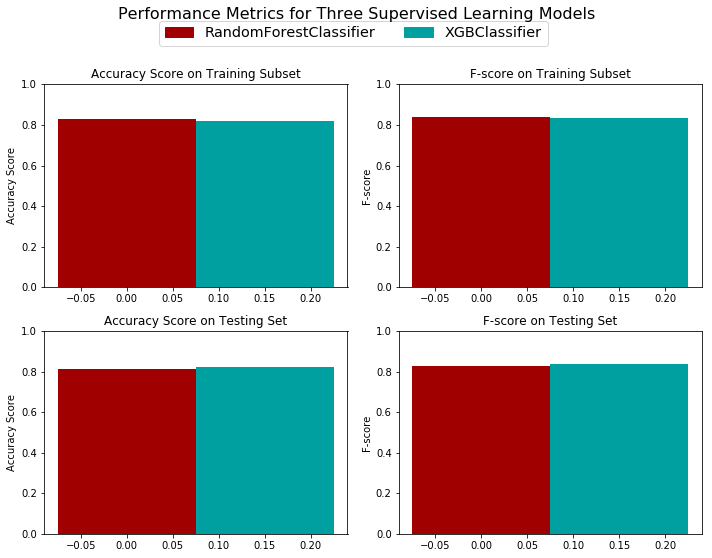

In [44]:
evaluate(results)

In [49]:
clf_B.feature_importances_

array([ 0.01904762,  0.31428573,  0.12063492,  0.21904762,  0.04761905,
        0.15238096,  0.01904762,  0.02222222,  0.01587302,  0.0031746 ,
        0.06031746,  0.00634921], dtype=float32)

In [ ]:
clf_B.feature_importances_

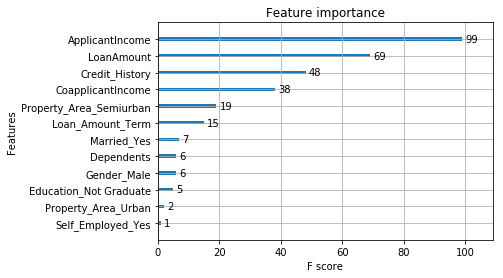

In [90]:
plt.figure(figsize=(10,6))
xgboost.plot_importance(clf_B)

In [99]:
D['prob'] = clf_B.predict_proba(X)[:,1]

In [108]:
D[D['prob']>0.7][con_var].describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.0
mean,0.694611,5328.065868,1528.706587,142.383234,343.329341,1.0
std,0.967624,5294.310110,2317.598015,77.099430,67.096266,0.0
min,0.000000,1759.000000,0.000000,25.000000,36.000000,1.0
25%,0.000000,2906.000000,0.000000,98.500000,360.000000,1.0
50%,0.000000,3859.000000,983.000000,124.000000,360.000000,1.0
75%,1.000000,5701.500000,2236.500000,171.000000,360.000000,1.0
max,3.000000,39147.000000,20000.000000,600.000000,480.000000,1.0


In [121]:
D[(D['prob']>0.55) & (D['prob']>0.45)].describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,prob
count,409.000000,409.000000,409.000000,409.000000,409.000000,409.0,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000
mean,0.760391,5228.288509,1575.545037,143.425428,343.628362,1.0,0.823961,0.652812,0.190709,0.132029,0.408313,0.305623,0.792176,0.712447
std,1.003081,4381.493237,2690.725515,78.514111,62.896887,0.0,0.381320,0.476659,0.393341,0.338937,0.492124,0.461235,0.406247,0.063958
min,0.000000,150.000000,0.000000,9.000000,36.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.596499
25%,0.000000,2920.000000,0.000000,100.000000,360.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.658779
50%,0.000000,3887.000000,1040.000000,128.000000,360.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.676242
75%,2.000000,5829.000000,2250.000000,170.000000,360.000000,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.787079
max,3.000000,39147.000000,33837.000000,600.000000,480.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.809651


In [109]:
D[D['prob']<0.2][con_var].describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.0
mean,0.855072,6171.753623,1659.811594,153.782609,336.521739,0.0
std,1.101808,10500.874338,2179.099985,92.203718,70.707061,0.0
min,0.000000,1500.000000,0.000000,45.000000,180.000000,0.0
25%,0.000000,2653.000000,0.000000,104.000000,360.000000,0.0
50%,0.000000,3588.000000,1430.000000,127.000000,360.000000,0.0
75%,2.000000,5516.000000,2426.000000,166.000000,360.000000,0.0
max,3.000000,81000.000000,11300.000000,600.000000,480.000000,0.0


In [118]:
data[(data['Credit_History']==0) & (data['Loan_Status']=='Y')]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,prob
122,LP001431,Female,No,0,Graduate,No,2137,8980.0,137.0,360.0,0.0,Semiurban,Y,0.125605
155,LP001536,Male,Yes,3,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y,0.147015
201,LP001677,Male,No,2,Graduate,No,4923,0.0,166.0,360.0,0.0,Semiurban,Y,0.138483
267,LP001882,Male,Yes,3,Graduate,No,4333,1811.0,160.0,360.0,0.0,Urban,Y,0.099903
326,LP002068,Male,No,0,Graduate,No,4917,0.0,130.0,360.0,0.0,Rural,Y,0.096892
453,LP002449,Male,Yes,0,Graduate,No,2483,2466.0,90.0,180.0,0.0,Rural,Y,0.099903
527,LP002706,Male,Yes,1,Not Graduate,No,5285,1430.0,161.0,360.0,0.0,Semiurban,Y,0.143084


In [116]:
data.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,prob
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000
mean,0.774059,5364.479079,1587.709038,144.920502,342.602510,0.855649,0.625503
std,1.017250,5678.931327,2621.167343,80.610082,64.052561,0.351814,0.220153
min,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.087368
25%,0.000000,2896.250000,0.000000,100.000000,360.000000,1.000000,0.647926
50%,0.000000,3859.000000,1106.000000,128.000000,360.000000,1.000000,0.676242
75%,2.000000,5827.000000,2253.750000,170.000000,360.000000,1.000000,0.777959
max,3.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,0.809651


In [85]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
DD = D.copy()
DD[con_var] = np.log1p(DD[con_var])

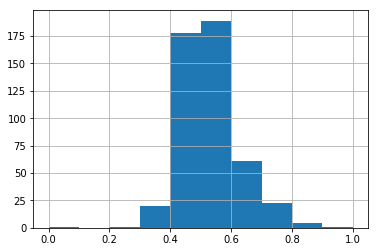

In [76]:
DD['ApplicantIncome'].hist()

In [75]:
DD.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
1,0.500000,0.543052,0.701790,0.624322,0.888111,1.0,1,1,0,0,0,0,0
2,0.000000,0.475649,0.000000,0.464381,0.888111,1.0,1,1,0,1,0,1,1
3,0.000000,0.451844,0.744629,0.608691,0.888111,1.0,1,1,1,0,0,1,1
4,0.000000,0.585909,0.000000,0.647763,0.888111,1.0,1,0,0,0,0,1,1
5,0.792481,0.569648,0.799871,0.802831,0.888111,1.0,1,1,0,1,0,1,1


In [86]:
X = DD.drop('Loan_Status_Y', axis=1)
y = DD['Loan_Status_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 382 samples.
Testing set has 96 samples.


In [88]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
LogReg.

In [89]:
# from scipy import stats
import statsmodels.api as sm

logit_mod = sm.Logit(y_train, X_train)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          Loan_Status_Y   No. Observations:                  382
Model:                          Logit   Df Residuals:                      370
Method:                           MLE   Df Model:                           11
Date:                Tue, 04 Dec 2018   Pseudo R-squ.:                    -inf
Time:                        17:57:55   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                       -95.632
                                        LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Dependents                  0.1284      0.290      0.443      0.658      -0.440       0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
